## **Problem Statement**

Projecting a society’s long-term electricity demand helps determine what capacity is needed for future energy generation. Accurate forecasts of electricity demand inform investment decisions about power generation and supporting network infrastructure. Of major interest to energy policymakers, power utilities, and private investors alike, forecasts are also essential for development professionals. Inaccurate forecasts, whether they over-or under predict demand, can have dire social and economic consequences. Underestimating demand results in supply shortages and forced power outages, with serious consequences for productivity and economic growth. Overestimating demand can lead to overinvestment in generation capacity, possible financial distress, and, ultimately, higher electricity prices. Several techniques have been developed over the last few decades to accurately predict the future of energy consumption. The main objective of this notebook is to create an energy demand forecasting system using Facebook Prophet. Facebook Prophet is an open-source library released by Facebook’s Core Data Science team.

The data I am going to use for this particular task is the new york electricity demand dataset.


## Import Packages

In [17]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import itertools

# Load the dataset

In [18]:
df = pd.read_csv('nyc_energy_consumption.csv')
df.head()

timeStamp  demand  precip   temp
0  2012-01-01 00:00:00  4937.5     0.0  46.13
1  2012-01-01 01:00:00  4752.1     0.0  45.89
2  2012-01-01 02:00:00  4542.6     0.0  45.04
3  2012-01-01 03:00:00  4357.7     0.0  45.03
4  2012-01-01 04:00:00  4275.5     0.0  42.61

## Inspecting data:

In [19]:
print ('The data has {0} rows and {1} columns'.format(df.shape[0],df.shape[1]))
numeric_data = df.select_dtypes(include=[np.number])
cat_data = df.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in the data".format(numeric_data.shape[1],cat_data.shape[1]))
print ("The duration of train data is from {} to {} ".format(df.timeStamp.min(),df.timeStamp.max()))

The data has 49205 rows and 4 columns
There are 3 numeric and 1 categorical columns in the data
The duration of train data is from 2012-01-01 00:00:00 to 2017-08-12 06:00:00 


In [20]:
def duplicate_data(data):
  dup_df = data[data.duplicated()]
  if dup_df.shape[0]==0:
    print("No duplicate data found in this dataset")
  else:
    print("Duplicate data found in this dataset.")
    data.drop_duplicates(keep='first', inplace=True)
    print("Duplicate data deleted from this dataset.")

In [21]:
duplicate_data(df)

No duplicate data found in this dataset


# Missing data:

In [22]:
def miss_data(data):
  if data.isnull().values.any()==False:
    return print('No missing value found for this dataset')
  else:
    col_name = data.columns[data.isnull().any()].tolist()
    return print('Column named {} have missing values'.format(', '.join(col_name)))

In [23]:
miss_data(df)

Column named demand, precip, temp have missing values


We have already idenified that which column have missing values.We will deal with that later.

In [24]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [25]:
fig_energy = px.line(df, x='timeStamp', y='demand',title='Energy Demand Per Hour(New York)')
fig_energy.update_xaxes(rangeslider_visible=True)
fig_energy.show()

In [26]:
fig_temp = px.line(df, x='timeStamp', y='temp',title='Temperature Per Hour(New York)')
fig_temp.update_xaxes(rangeslider_visible=True)
fig_temp.show()


## Resample Hourly Data to Daily Data

Resampling is used in time series data. This is a convenient method for frequency conversion and resampling of time series data.Our data has a lot of data points due to the hourly records.To simplify I want to take the average of the hourly data to provide a daily value using the .resample('D').mean() method.



In [27]:
df=df.set_index('timeStamp')
df_max=df[['demand','temp']].resample('D').max()
df_min=df[['demand','temp']].resample('D').min()
df=df[['demand','temp']].resample('D').mean()
miss_data(df)
df[df.temp.isnull()]

Column named demand, temp have missing values


demand  temp
timeStamp                    
2015-12-28  5510.776333   NaN

For 28th december,2015 we dont have temperatre data.Its possible to collect the data from external sources.But we are going to fill this up using previous day's data.

In [28]:
df['temp']=df['temp'].fillna(method='ffill')
df[df.demand.isnull()]

demand       temp
timeStamp                    
2017-08-11     NaN  72.767917
2017-08-12     NaN  69.771429

We have already checked the duration of the data.From the above, it's clear that only the last two days have no demand data. For the sake of simplicity, we will drop the last two days' data only.

In [29]:
df = df.dropna()
df.head()

demand       temp
timeStamp                         
2012-01-01  4954.833333  46.510000
2012-01-02  5302.954167  40.496667
2012-01-03  6095.512500  26.672500
2012-01-04  6336.266667  20.585000
2012-01-05  6130.245833  33.577500

In [30]:
fig_daily_energy = px.line(df, x=df.index, y='demand',title='Daily Avg Energy Demand per Hour(NewYork)')
fig_daily_energy.update_xaxes(rangeslider_visible=True)
fig_daily_energy.show()

In [31]:
fig_daily_temp = px.line(df, x=df.index, y='temp',title='Daily Avg temperature per Hour(NewYork)')
fig_daily_temp.update_xaxes(rangeslider_visible=True)
fig_daily_temp.show()

# Forecasting with Facebook Prophet
## Data preparation(Univariate time series model)

Prophet requires input as a dataframe with two columns:

* ds: datetime column

* y: numeric column which represents the measurement we wish to forecast.

Our data is almost ready. We just need to rename columns timeStamp and demand, respectively, as **ds** and **y**.

In [32]:
df_daily_uni=df.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')
df_daily_uni.head()

ds            y
0 2012-01-01  4954.833333
1 2012-01-02  5302.954167
2 2012-01-03  6095.512500
3 2012-01-04  6336.266667
4 2012-01-05  6130.245833

## Train Test split:

For training purposes, I will use data up to May 31, 2017.
The last 71 days are preserved for testing.

In [33]:
train_df=df_daily_uni[(df_daily_uni['ds'] >= '2012-01-01') & (df_daily_uni['ds'] <= '2017-05-31')]
test_df=df_daily_uni[(df_daily_uni['ds'] > '2017-05-31')]

# Training

The default value for confidence interval is 80%.I have modified this to make it 95%.

In [34]:
model_1 = Prophet(interval_width=0.95,yearly_seasonality=True)
model_1.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecast

In order to forecast we first need to create a dataframe that will save our predictions. Method **make_future_dataframe** builds a dataframe that extends into the future a specified number of days. In our case, we will predict 71 days into the future.

By default the dataframe created includes the dates from the history, so we see the model fit as well.

In [35]:
future_df = model_1.make_future_dataframe(periods=test_df.shape[0])
future_df.head()

ds
0 2012-01-01
1 2012-01-02
2 2012-01-03
3 2012-01-04
4 2012-01-05

In [36]:
future_df.tail()

ds
2044 2017-08-06
2045 2017-08-07
2046 2017-08-08
2047 2017-08-09
2048 2017-08-10

To make predictions we apply method **predict** on the future dataframe that we have just generated.


# Forecast Dataframe

In [37]:
forecast_df = model_1.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
forecast_df.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2012-01-01  6028.687160  4197.497223  6057.606222  6028.687160  6028.687160   
1 2012-01-02  6029.162971  4905.233765  6741.298657  6029.162971  6029.162971   
2 2012-01-03  6029.638783  5024.783218  6718.401736  6029.638783  6029.638783   
3 2012-01-04  6030.114594  5021.360378  6775.948963  6030.114594  6030.114594   
4 2012-01-05  6030.590406  4932.598550  6847.182659  6030.590406  6030.590406   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0     -927.735704           -927.735704           -927.735704 -543.000047   
1     -247.473815           -247.473815           -247.473815  128.447364   
2     -129.157539           -129.157539           -129.157539  237.200975   
3     -119.795592           -119.795592           -119.795592  236.319032   
4     -143.678858           -143.678858           -143.678858  201.588059   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0   -543.000047   -543.000047 -384.735658   -384.735658   -384.735658   
1    128.447364    128.447364 -375.921179   -375.921179   -375.921179   
2    237.200975    237.200975 -366.358514   -366.358514   -366.358514   
3    236.319032    236.319032 -356.114624   -356.114624   -356.114624   
4    201.588059    201.588059 -345.266916   -345.266916   -345.266916   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  5100.951455  
1                         0.0  5781.689156  
2                         0.0  5900.481244  
3                         0.0  5910.319002  
4                         0.0  5886.911548

In [38]:
forecast_df.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2044 2017-08-06  6049.605581  5853.884264  7655.587273  6035.957365   
2045 2017-08-07  6049.559246  6521.369137  8443.598449  6035.814239   
2046 2017-08-08  6049.512911  6627.648738  8444.738185  6035.679455   
2047 2017-08-09  6049.466576  6575.868681  8489.518463  6035.416340   
2048 2017-08-10  6049.420241  6604.072251  8471.425307  6035.153224   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2044  6060.975897      747.642176            747.642176            747.642176   
2045  6061.236334     1404.079510           1404.079510           1404.079510   
2046  6061.496772     1501.070683           1501.070683           1501.070683   
2047  6061.757209     1491.683758           1491.683758           1491.683758   
2048  6062.017646     1451.644603           1451.644603           1451.644603   

          weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
2044 -543.000047   -543.000047   -543.000047  1290.642222   1290.642222   
2045  128.447364    128.447364    128.447364  1275.632146   1275.632146   
2046  237.200975    237.200975    237.200975  1263.869708   1263.869708   
2047  236.319032    236.319032    236.319032  1255.364726   1255.364726   
2048  201.588059    201.588059    201.588059  1250.056544   1250.056544   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
2044   1290.642222                   0.0                         0.0   
2045   1275.632146                   0.0                         0.0   
2046   1263.869708                   0.0                         0.0   
2047   1255.364726                   0.0                         0.0   
2048   1250.056544                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2044                         0.0  6797.247757  
2045                         0.0  7453.638756  
2046                         0.0  7550.583594  
2047                         0.0  7541.150334  
2048                         0.0  7501.064844

The forecast dataframe contains Prophet’s prediction for demand. Because we've also passed historical dates, it provides an in-sample fit that we can use to evaluate our model.

As you can see, forecast includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

## Forecast Plot

To plot the forecast you just need to call method .plot() on your forecast dataframe.

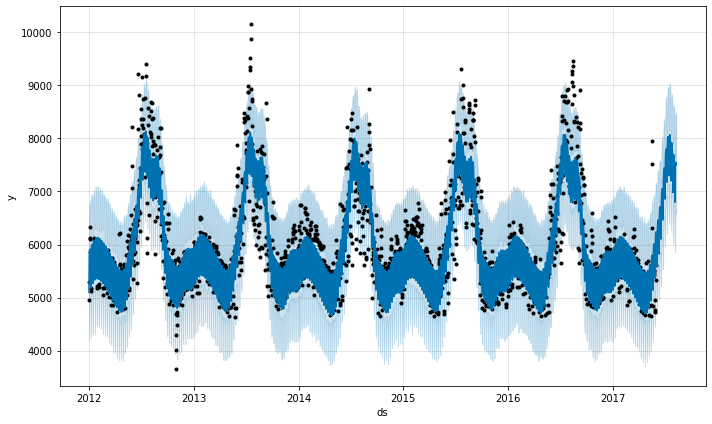

In [39]:
plot_fig_1 = model_1.plot(forecast_df)

We will generate the same using plotly.This graph is very much interactive as we can see the actual/predicted value when we hover our cursor on the graph.

In [40]:
plot_fig_2 = plot_plotly(model_1, forecast_df)  
py.iplot(plot_fig_2)

In the forecast plot above, deep blue line is forecasted demand '**y_hat**', black dots are actual demand '**y**'. The light blue shade is 95% confidence interval around the forecast. The uncertainty interval in this region is bounded by '**yhat_lower**' and '**yhat_upper**' values.

## Component Plots

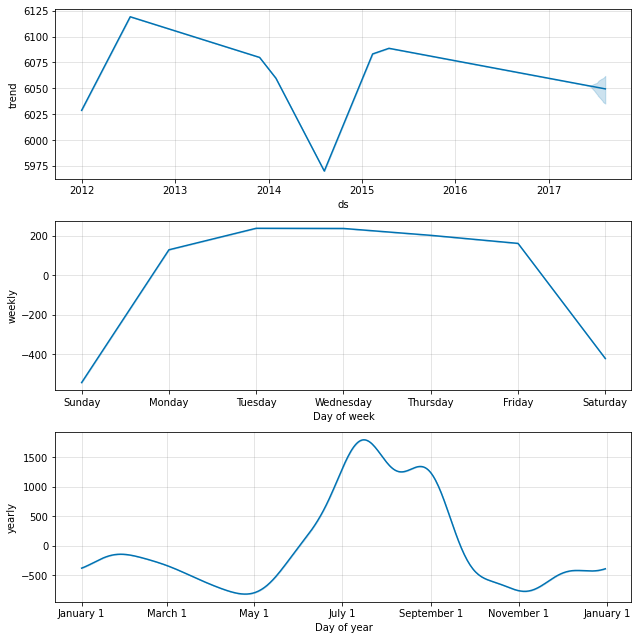

In [41]:
plot_fig_3 = model_1.plot_components(forecast_df)

We can observe the following on forecast components plotted above:

* Trend component:
 *  There's upward trend upto mid of 2012 and then a downward trend upto mid of 2014 and then again there is an upward trend upto March,2015.Since then we observed slightly downward trend. 
* Weekly seasonality component:
 * The weekly seasonality shows that people uses more electricity on weekdays. In particular, we observe a increase on demand from Sunday to Monday. This might point to a weekend effect.

* Yearly seasonality component:
 * From May to September the demand is pretty high and the reason is the summer months otherwise in January to March or April around the time frame the demand is lower as those are winter months. 
 


## Trend Changepoints

In the plot below, the dotted lines represent the changepoints for the given time series.

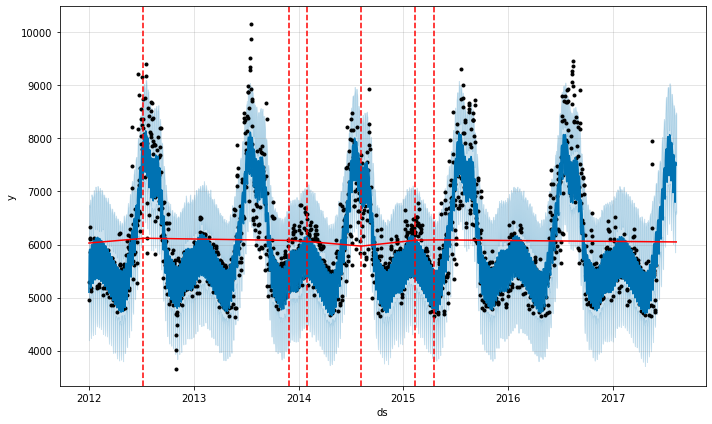

In [42]:
plot_fig_1 = model_1.plot(forecast_df)
plot_fig_4 = add_changepoints_to_plot(plot_fig_1.gca(), model_1, forecast_df)

# Evaluate model

In [43]:
all_model_MAE=[]
all_model_MAPE=[]

In [44]:
eval_df = pd.merge(train_df, forecast_df,on='ds')
eval_df  = eval_df[['ds','yhat_lower','yhat_upper','yhat','y']]
eval_df.head()

ds   yhat_lower   yhat_upper         yhat            y
0 2012-01-01  4197.497223  6057.606222  5100.951455  4954.833333
1 2012-01-02  4905.233765  6741.298657  5781.689156  5302.954167
2 2012-01-03  5024.783218  6718.401736  5900.481244  6095.512500
3 2012-01-04  5021.360378  6775.948963  5910.319002  6336.266667
4 2012-01-05  4932.598550  6847.182659  5886.911548  6130.245833

To evaluate this model we will be using MAE and MAPE.Using this, we can compare and find out which model is the best model.

In [45]:
# calculate MAE between observed and predicted values 
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values
mae_model_1 = mean_absolute_error(y_true, y_pred)
all_model_MAE.append(mae_model_1)
print('MAE: %.3f' % mae_model_1)

MAE: 321.375


In [46]:
mape_model_1 = mean_absolute_percentage_error(y_true, y_pred)
all_model_MAPE.append(mape_model_1)
print('MAPE: %.3f' % mape_model_1)

MAPE: 0.051


In addition, to calculating metrics let's plot both actual and predicted data.

In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['y'],
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=eval_df['ds'], y=eval_df['yhat'],
                    mode='lines+markers',
                    name='Predicted'))

*From* the graph, it seems that the model is able to fit the data points well.

# Fine tuning hyperparameters


Is it possible to make it better??

We can apply grid search and try to fine tune the hyperparameters. Let's apply it and try to find hyperparameters that may give us lower MAPE.

Here we try different values of changepoint_prior_scale and seasonality_prior_scale. changepoint_prior_scale determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints.While seasonality_prior_scale controls the flexibility of the seasonality. 

In [48]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1,0.005,0.05, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(interval_width=0.95,yearly_seasonality=True,**params)
    m.fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='71 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbd4ad2b90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbd6182d90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbd2952110>
INFO:fbprophet:Disabling daily seasonality. Run p

In [49]:
tuning_hp_df = pd.DataFrame(tuning_results)
tuning_hp_df.sort_values(['mae','mape'])

changepoint_prior_scale  seasonality_prior_scale         mae      mape
12                    0.005                     0.01  374.927740  0.059483
13                    0.005                     0.10  380.394750  0.060431
4                     0.010                     0.01  380.891996  0.060449
14                    0.005                     1.00  382.355535  0.060763
15                    0.005                    10.00  383.688326  0.061002
5                     0.010                     0.10  391.906487  0.062459
7                     0.010                    10.00  391.970212  0.062452
6                     0.010                     1.00  392.087659  0.062473
0                     0.001                     0.01  393.104361  0.063064
1                     0.001                     0.10  401.530698  0.064526
2                     0.001                     1.00  404.654006  0.065072
3                     0.001                    10.00  405.152911  0.065244
17                    0.050                     0.10  434.445393  0.070213
19                    0.050                    10.00  434.487191  0.070214
18                    0.050                     1.00  434.720725  0.070254
8                     0.100                     0.01  436.552107  0.069886
16                    0.050                     0.01  439.589570  0.070791
9                     0.100                     0.10  440.147854  0.071337
11                    0.100                    10.00  440.151602  0.071322
10                    0.100                     1.00  440.270857  0.071357
21                    0.500                     0.10  464.096072  0.075159
22                    0.500                     1.00  466.079207  0.075532
23                    0.500                    10.00  466.662694  0.075647
20                    0.500                     0.01  592.577607  0.096649

In [50]:
tuning_hp_df.sort_values(['mape','mae'])

changepoint_prior_scale  seasonality_prior_scale         mae      mape
12                    0.005                     0.01  374.927740  0.059483
13                    0.005                     0.10  380.394750  0.060431
4                     0.010                     0.01  380.891996  0.060449
14                    0.005                     1.00  382.355535  0.060763
15                    0.005                    10.00  383.688326  0.061002
7                     0.010                    10.00  391.970212  0.062452
5                     0.010                     0.10  391.906487  0.062459
6                     0.010                     1.00  392.087659  0.062473
0                     0.001                     0.01  393.104361  0.063064
1                     0.001                     0.10  401.530698  0.064526
2                     0.001                     1.00  404.654006  0.065072
3                     0.001                    10.00  405.152911  0.065244
8                     0.100                     0.01  436.552107  0.069886
17                    0.050                     0.10  434.445393  0.070213
19                    0.050                    10.00  434.487191  0.070214
18                    0.050                     1.00  434.720725  0.070254
16                    0.050                     0.01  439.589570  0.070791
11                    0.100                    10.00  440.151602  0.071322
9                     0.100                     0.10  440.147854  0.071337
10                    0.100                     1.00  440.270857  0.071357
21                    0.500                     0.10  464.096072  0.075159
22                    0.500                     1.00  466.079207  0.075532
23                    0.500                    10.00  466.662694  0.075647
20                    0.500                     0.01  592.577607  0.096649

In [51]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.01}


## Model Training--Univariant (After hyperparameter tunning)

In [52]:
model_2 = Prophet(interval_width=0.95, yearly_seasonality=True, 
            changepoint_prior_scale=best_params['changepoint_prior_scale'], 
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model_2 = model_2.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
forecast_df_2 = model_2.predict(future_df)

In [54]:
plot_fig_5 = plot_plotly(model_2, forecast_df_2)  
py.iplot(plot_fig_5)

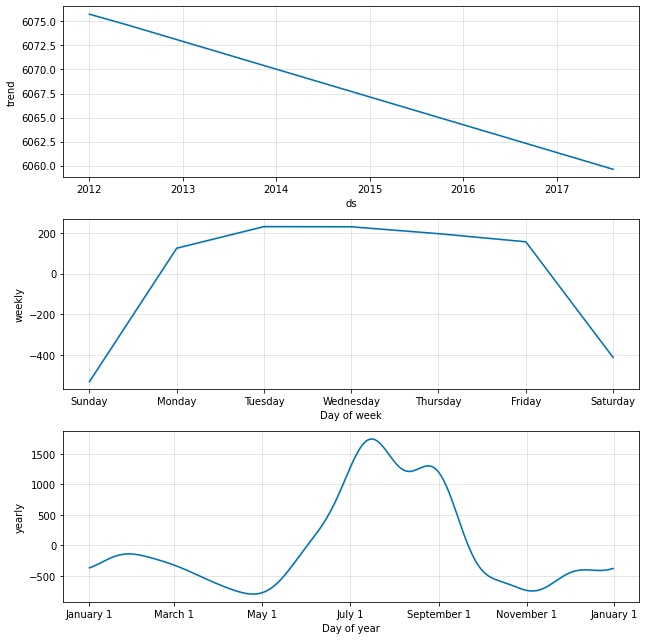

In [55]:
plot_fig_6 = model_2.plot_components(forecast_df_2)

In [56]:
eval_df_2 = pd.merge(train_df, forecast_df_2,on='ds')
eval_df_2  = eval_df_2[['ds','yhat_lower','yhat_upper','yhat','y']]
eval_df_2.head()

ds   yhat_lower   yhat_upper         yhat            y
0 2012-01-01  4228.149633  6062.292086  5168.944832  4954.833333
1 2012-01-02  4892.067217  6821.870139  5834.121563  5302.954167
2 2012-01-03  4999.458054  6823.893063  5949.451566  6095.512500
3 2012-01-04  5070.364563  6835.002152  5958.193030  6336.266667
4 2012-01-05  4980.693453  6863.191330  5934.446668  6130.245833

In [57]:
y_true = eval_df_2['y'].values
y_pred = eval_df_2['yhat'].values
mae_model_2 = mean_absolute_error(y_true, y_pred)
all_model_MAE.append(mae_model_2)
print('MAE: %.3f' % mae_model_2)

MAE: 323.293


In [58]:
mape_model_2 = mean_absolute_percentage_error(y_true, y_pred)
all_model_MAPE.append(mape_model_2)
print('MAPE: %.3f' % mape_model_2)

MAPE: 0.051


We did not achieve good results after hyperparameter tuning.It seems our previous model did better without hyperparameter tuning.We will try to improve our model using Multivariate analysis. For this, we will consider temperate as it may play a key role to improve our model's performance. 

# Multivariate analysis:

In [59]:
df_daily_multi=df.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y'}, axis='columns')
df_daily_multi['Month'] = df_daily_multi.ds.dt.month
df_daily_multi = df_daily_multi.dropna()
df_daily_multi.head()

ds            y       temp  Month
0 2012-01-01  4954.833333  46.510000      1
1 2012-01-02  5302.954167  40.496667      1
2 2012-01-03  6095.512500  26.672500      1
3 2012-01-04  6336.266667  20.585000      1
4 2012-01-05  6130.245833  33.577500      1

We are interested to detect those days for which our model produced bad results.Corresponding temperatures(avg, max,min) for those days will also be observed to identify any possible relationship with bad forecasting.

In [60]:
df_max['temp']=df_max['temp'].fillna(method='ffill')
df_min['temp']=df_min['temp'].fillna(method='ffill')
df_max_mul=df_max.reset_index()[['timeStamp','temp']].rename({'timeStamp':'ds','temp':'max_temp'}, axis='columns')
df_min_mul=df_min.reset_index()[['timeStamp','temp']].rename({'timeStamp':'ds','temp':'min_temp'}, axis='columns')

In [61]:
eval_df_2['error']=abs(eval_df_2['y']-eval_df_2['yhat'])
eval_df_2= pd.merge(pd.merge(pd.merge(eval_df_2, df_max_mul, on='ds'),df_daily_multi[['ds','temp']],on='ds'),df_min_mul[['ds','min_temp']],on='ds')
eval_df_2.sort_values('error',ascending=False)

ds   yhat_lower   yhat_upper         yhat             y  \
1687 2016-08-14  5867.246444  7690.125487  6757.224525   8989.980375   
172  2012-06-21  6118.074249  7843.450310  7006.091455   9219.370833   
565  2013-07-19  7068.627978  8910.309565  7958.767816  10163.279167   
1686 2016-08-13  5903.579891  7743.753943  6870.509591   9067.921292   
1965 2017-05-19  4878.609647  6732.179631  5794.556284   7950.161333   
...         ...          ...          ...          ...           ...   
430  2013-03-06  5002.465498  6821.740642  5932.763075   5933.529167   
1471 2016-01-11  5007.753644  6829.517984  5920.536347   5921.199667   
1163 2015-03-09  4912.439647  6738.911758  5796.471536   5795.929250   
334  2012-11-30  4866.716690  6691.669778  5773.359537   5773.625000   
853  2014-05-03  3907.321920  5841.650596  4893.827205   4893.683333   

            error  max_temp       temp  min_temp  
1687  2232.755850     93.67  86.650000     80.96  
172   2213.279378     93.39  86.916667     75.33  
565   2204.511350     95.78  89.606667     83.23  
1686  2197.411701     94.86  87.426250     80.29  
1965  2155.605050     91.27  81.322500     68.84  
...           ...       ...        ...       ...  
430      0.766092     42.58  39.794583     35.76  
1471     0.663320     39.74  32.115417     26.46  
1163     0.542286     52.16  44.138750     35.88  
334      0.265463     43.04  40.027500     36.68  
853      0.143872     65.62  59.918333     53.76  

[1978 rows x 9 columns]

It seems our model did comparatively well when the temperature was not so high. The opposite thing was observed when the temperature was high enough.Let's check the correlation plot to understand it better.


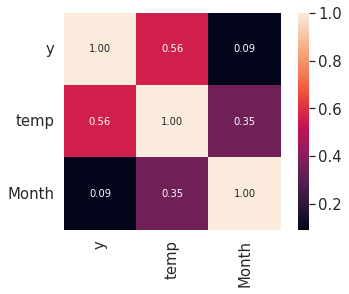

In [62]:
corrmat = df_daily_multi.corr()
cols = corrmat.nlargest(7, 'y')['y'].index
cm = np.corrcoef(df_daily_multi[cols].values.T)
sns.set(font_scale=1.35)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(10,8)})
plt.show()

The temperature has a good correlation with the target variable.
We can create several relevant features based on this to 
increase the effectiveness of the model in terms of 
forecasting.

In [63]:
df_daily_multi=pd.merge(pd.merge(df_daily_multi, df_max_mul, on='ds'),df_min_mul[['ds','min_temp']],on='ds')

In [64]:
df_daily_multi.query('temp > 55')[['y','temp']].corr()

y      temp
y     1.000000  0.879896
temp  0.879896  1.000000

In [65]:
df_daily_multi.query('max_temp >60')[['y','max_temp']].corr()

y  max_temp
y         1.0000    0.8305
max_temp  0.8305    1.0000

In [66]:
df_daily_multi.query('min_temp >50')[['y','min_temp']].corr()

y  min_temp
y         1.000000  0.876557
min_temp  0.876557  1.000000

We observed strong correlation with target variable for: 

i) **temp** above 55

ii) **max_temp** above 60

iii) **min_temp** above 50

We will try to create new features based on this relationship.We will also try to create a new feature based on month. 

In [68]:
def summer_temp(temp):
  if temp > 55:
    return 1
  else:
    return 0

def summer_temp_min(min_temp):
  if min_temp > 50:
    return 1
  else:
    return 0    

def summer_temp_max(max_temp):
  if max_temp > 60:
    return 1
  else:
    return 0   


df_daily_multi['summer_temp']=df_daily_multi['temp'].apply(summer_temp)    

df_daily_multi['summer_temp_min']=df_daily_multi['min_temp'].apply(summer_temp_min)    

df_daily_multi['summer_temp_max']=df_daily_multi['max_temp'].apply(summer_temp_max)    

In [70]:
df_daily_multi

ds            y       temp  Month  max_temp  min_temp  \
0    2012-01-01  4954.833333  46.510000      1     50.77     38.78   
1    2012-01-02  5302.954167  40.496667      1     49.78     33.57   
2    2012-01-03  6095.512500  26.672500      1     33.14     16.47   
3    2012-01-04  6336.266667  20.585000      1     31.83     13.40   
4    2012-01-05  6130.245833  33.577500      1     39.16     27.31   
...         ...          ...        ...    ...       ...       ...   
2044 2017-08-06  5702.361542  70.129167      8     78.62     60.96   
2045 2017-08-07  6398.154167  68.203750      8     70.86     65.66   
2046 2017-08-08  6471.626042  71.039167      8     79.24     66.17   
2047 2017-08-09  6811.112167  73.852500      8     84.61     63.79   
2048 2017-08-10  5582.297000  75.217500      8     83.69     67.06   

      summer_temp  summer_temp_min  summer_temp_max  
0               0                0                0  
1               0                0                0  
2               0                0                0  
3               0                0                0  
4               0                0                0  
...           ...              ...              ...  
2044            1                1                1  
2045            1                1                1  
2046            1                1                1  
2047            1                1                1  
2048            1                1                1  

[2049 rows x 9 columns]

In [71]:
df_daily_multi['month_bins']=pd.cut(df_daily_multi['Month'],bins=3, labels=False)

In [72]:
train_df=df_daily_multi[(df_daily_multi['ds'] >= '2012-01-01') & (df_daily_multi['ds'] <= '2017-05-31')]
test_df=df_daily_multi[(df_daily_multi['ds'] > '2017-05-31')]

In [73]:
train_df.head()

ds            y       temp  Month  max_temp  min_temp  summer_temp  \
0 2012-01-01  4954.833333  46.510000      1     50.77     38.78            0   
1 2012-01-02  5302.954167  40.496667      1     49.78     33.57            0   
2 2012-01-03  6095.512500  26.672500      1     33.14     16.47            0   
3 2012-01-04  6336.266667  20.585000      1     31.83     13.40            0   
4 2012-01-05  6130.245833  33.577500      1     39.16     27.31            0   

   summer_temp_min  summer_temp_max  month_bins  
0                0                0           0  
1                0                0           0  
2                0                0           0  
3                0                0           0  
4                0                0           0

## Model Training--Multivariate Analysis

In [74]:
model_3 = Prophet(interval_width=0.95,yearly_seasonality=True)
model_3.add_regressor('summer_temp',standardize=False)
model_3.add_regressor('summer_temp_min',standardize=False)
model_3.add_regressor('summer_temp_max',standardize=False)
model_3.add_regressor('month_bins',standardize=False,mode='additive')
model_3.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future_df_3 = model_3.make_future_dataframe(periods=test_df.shape[0])
future_df_3['summer_temp'] = df_daily_multi['summer_temp']
future_df_3['summer_temp_min'] = df_daily_multi['summer_temp_min']
future_df_3['summer_temp_max'] = df_daily_multi['summer_temp_max']
future_df_3['month_bins'] = df_daily_multi['month_bins']
forecast_df_3 = model_3.predict(future_df_3)

In [76]:
plot_fig_7 = plot_plotly(model_3, forecast_df_3)  
py.iplot(plot_fig_7)

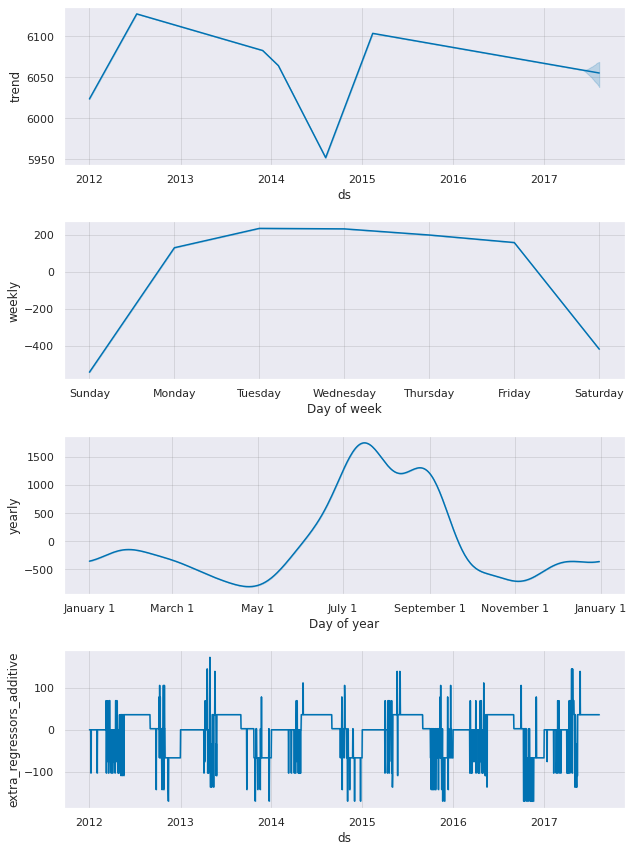

In [77]:
plot_fig_8 = model_3.plot_components(forecast_df_3)

In [78]:
eval_df_3 = pd.merge(train_df, forecast_df_3,on='ds')
eval_df_3  = eval_df_3[['ds','yhat_lower','yhat_upper','yhat','y']]
eval_df_3.head()

ds   yhat_lower   yhat_upper         yhat            y
0 2012-01-01  4194.414897  6067.717764  5123.543387  4954.833333
1 2012-01-02  4909.599439  6721.493857  5801.863394  5302.954167
2 2012-01-03  4996.290236  6851.023615  5912.944194  6095.512500
3 2012-01-04  5043.353819  6833.328122  5917.616919  6336.266667
4 2012-01-05  4940.734662  6770.304558  5892.551815  6130.245833

In [79]:
y_true = eval_df_3['y'].values
y_pred = eval_df_3['yhat'].values
mae_model_3 = mean_absolute_error(y_true, y_pred)
all_model_MAE.append(mae_model_3)
print('MAE: %.3f' % mae_model_3)

MAE: 318.558


In [80]:
mape_model_3 = mean_absolute_percentage_error(y_true, y_pred)
all_model_MAPE.append(mape_model_3)
print('MAPE: %.3f' % mape_model_3)

MAPE: 0.050


## Fine tuning hyperparameter---Multivariate Analysis



In [82]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1,0.005,0.05, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(interval_width=0.95,yearly_seasonality=True,**params)
    m.add_regressor('summer_temp',standardize=False)
    m.add_regressor('summer_temp_min',standardize=False)
    m.add_regressor('summer_temp_max',standardize=False)
    m.add_regressor('month_bins',standardize=False,mode='additive')
    m.fit(train_df)
    df_cv = cross_validation(m, horizon='71 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbcd976210>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbce57f510>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 44 forecasts with cutoffs between 2013-01-14 12:00:00 and 2017-03-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcbd2a376d0>
INFO:fbprophet:Disabling daily seasonality. Run p

In [83]:
tuning_hp_df = pd.DataFrame(tuning_results)
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.01}


## Model Training--Multivariate (After hyperparameter tunning)


In [84]:
model_4 = Prophet(interval_width=0.95, yearly_seasonality=True, 
            changepoint_prior_scale=best_params['changepoint_prior_scale'], 
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model_4.add_regressor('summer_temp',standardize=False)
model_4.add_regressor('summer_temp_min',standardize=False)
model_4.add_regressor('summer_temp_max',standardize=False)
model_4.add_regressor('month_bins',standardize=False,mode='additive')
model_4 = model_4.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
future_df_4 = model_4.make_future_dataframe(periods=test_df.shape[0])
future_df_4['summer_temp'] = df_daily_multi['summer_temp']
future_df_4['summer_temp_min'] = df_daily_multi['summer_temp_min']
future_df_4['summer_temp_max'] = df_daily_multi['summer_temp_max']
future_df_4['month_bins'] = df_daily_multi['month_bins']
forecast_df_4 = model_4.predict(future_df_4)

In [86]:
plot_fig_9 = plot_plotly(model_4, forecast_df_4)  
py.iplot(plot_fig_9)

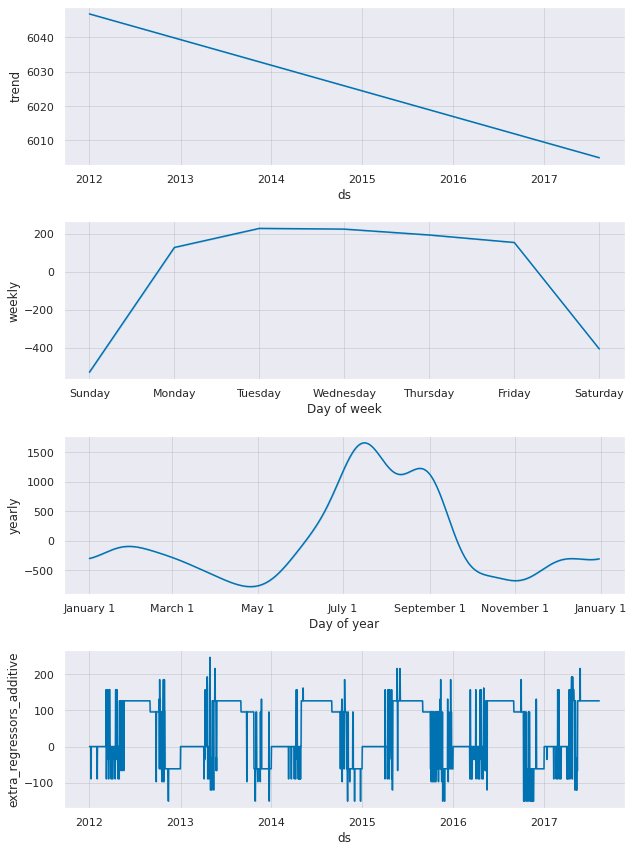

In [87]:
plot_fig_10 = model_4.plot_components(forecast_df_4)

In [88]:
eval_df_4 = pd.merge(train_df, forecast_df_4,on='ds')
eval_df_4  = eval_df_4[['ds','yhat_lower','yhat_upper','yhat','y']]
eval_df_4.head()

ds   yhat_lower   yhat_upper         yhat            y
0 2012-01-01  4329.292245  6213.143177  5212.912510  4954.833333
1 2012-01-02  4971.099334  6812.737047  5875.081150  5302.954167
2 2012-01-03  5069.579586  6956.345282  5981.528633  6095.512500
3 2012-01-04  5095.111039  6816.116104  5984.541961  6336.266667
4 2012-01-05  5036.509309  6959.353249  5961.239497  6130.245833

In [89]:
y_true = eval_df_4['y'].values
y_pred = eval_df_4['yhat'].values
mae_model_4 = mean_absolute_error(y_true, y_pred)
all_model_MAE.append(mae_model_4)
print('MAE: %.3f' % mae_model_4)

MAE: 321.762


In [90]:
mape_model_4 = mean_absolute_percentage_error(y_true, y_pred)
all_model_MAPE.append(mape_model_4)
print('MAPE: %.3f' % mape_model_4)

MAPE: 0.051


## Performance evaluation
So far we have trained 4 different models.Let's compare the values of the metrics of the different models.

In [99]:
eval_df = pd.DataFrame(columns=['Model Name', 'MAE', 'MAPE'])
eval_df['Model Name']=['Model_1','Model_2','Model_3','Model_4']
eval_df['MAE']=all_model_MAE
eval_df['MAPE']=all_model_MAPE
eval_df

Model Name         MAE      MAPE
0    Model_1  321.374740  0.050690
1    Model_2  323.293226  0.050872
2    Model_3  318.557500  0.050191
3    Model_4  321.762270  0.050586

Its clear from the table that Model 3 was our best model.What if we include US-Holidays? Would it improve further the results obtained by the best model?



## Best Model by adding US Holidays

In [100]:
model_5 = Prophet(interval_width=0.95,yearly_seasonality=True)
model_5.add_regressor('summer_temp',standardize=False)
model_5.add_regressor('summer_temp_min',standardize=False)
model_5.add_regressor('summer_temp_max',standardize=False)
model_5.add_regressor('month_bins',standardize=False,mode='additive')
model_5.add_country_holidays(country_name='US')
model_5.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [101]:
future_df_5 = model_5.make_future_dataframe(periods=test_df.shape[0])
future_df_5['summer_temp'] = df_daily_multi['summer_temp']
future_df_5['summer_temp_min'] = df_daily_multi['summer_temp_min']
future_df_5['summer_temp_max'] = df_daily_multi['summer_temp_max']
future_df_5['month_bins'] = df_daily_multi['month_bins']
forecast_df_5 = model_5.predict(future_df_5)

In [102]:
plot_fig_11 = plot_plotly(model_5, forecast_df_5)  
py.iplot(plot_fig_11)

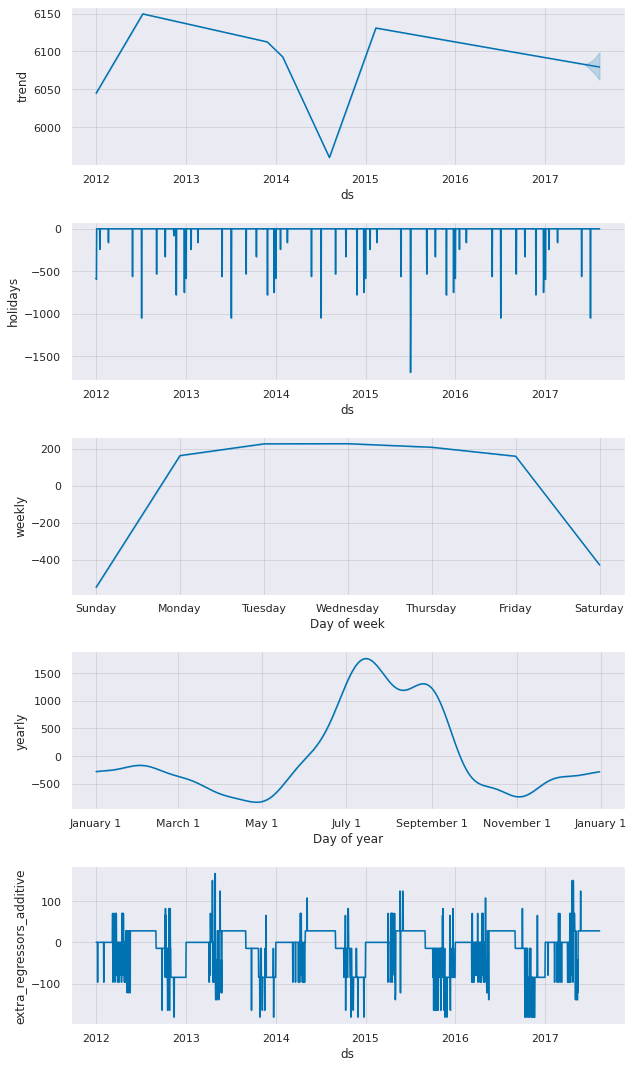

In [104]:
plot_fig_12 = model_5.plot_components(forecast_df_5)

In [105]:
eval_df_5 = pd.merge(train_df, forecast_df_5,on='ds')
eval_df_5  = eval_df_5[['ds','yhat_lower','yhat_upper','yhat','y']]
eval_df_5.head()

ds   yhat_lower   yhat_upper         yhat            y
0 2012-01-01  3731.501633  5491.547519  4628.254927  4954.833333
1 2012-01-02  4402.056004  6215.095790  5333.512441  5302.954167
2 2012-01-03  5100.345363  6915.108049  5994.492048  6095.512500
3 2012-01-04  5137.169885  6870.864447  5998.325659  6336.266667
4 2012-01-05  5131.961167  6918.650327  5981.866099  6130.245833

In [106]:
y_true = eval_df_5['y'].values
y_pred = eval_df_5['yhat'].values
mae_model_5 = mean_absolute_error(y_true, y_pred)
all_model_MAE.append(mae_model_5)
print('MAE: %.3f' % mae_model_5)

MAE: 312.549


In [107]:
mape_model_5 = mean_absolute_percentage_error(y_true, y_pred)
all_model_MAPE.append(mape_model_5)
print('MAPE: %.3f' % mape_model_5)

MAPE: 0.049


We achieved a good improvement by adding holiday to model 3.